# Paper Implementation
## END-TO-END TRAINED CNN ENCODER-DECODER NETWORKS FOR IMAGE STEGANOGRAPHY - Atique </i> $et.al$
## Tensorflow 2.0
###  Notebook Author: Saad Zia

In [1]:
from IPython import display
import numpy as np
import tensorflow as tf
import pickle

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
# For process to not allocate entire GPU memory

physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

#### Setting up Data Pipeline

In [3]:
(x, y), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [4]:
x = x.astype(np.float32)
x_test = x_test.astype(np.float32)

#### Setting up tf.keras Model

In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input

In [15]:
tf.keras.backend.set_floatx('float32')
tf.keras.backend.floatx()

'float32'

In [16]:
from model_skip_branched.encoder import EncoderNetwork
from model_skip_branched.decoder import DecoderNetwork

In [17]:
carrier_image_shape = (32, 32, 3)
payload_image_shape = (32, 32, 3)

encoder_network = EncoderNetwork(carrier_shape=carrier_image_shape,
                                 payload_shape=payload_image_shape)
decoder_network = DecoderNetwork(target_image_shape=payload_image_shape)

In [18]:
input_carrier = Input(shape=carrier_image_shape, name='input_carrier')
input_payload = Input(shape=payload_image_shape, name='input_payload')

In [19]:
encoded_output = encoder_network.get_network(input_carrier, input_payload)
decoded_output, decoded_host_output = decoder_network.get_network(encoded_output)

In [20]:
steganography_model = Model(inputs=[input_carrier, input_payload],
                            outputs=[encoded_output, decoded_output, decoded_host_output])

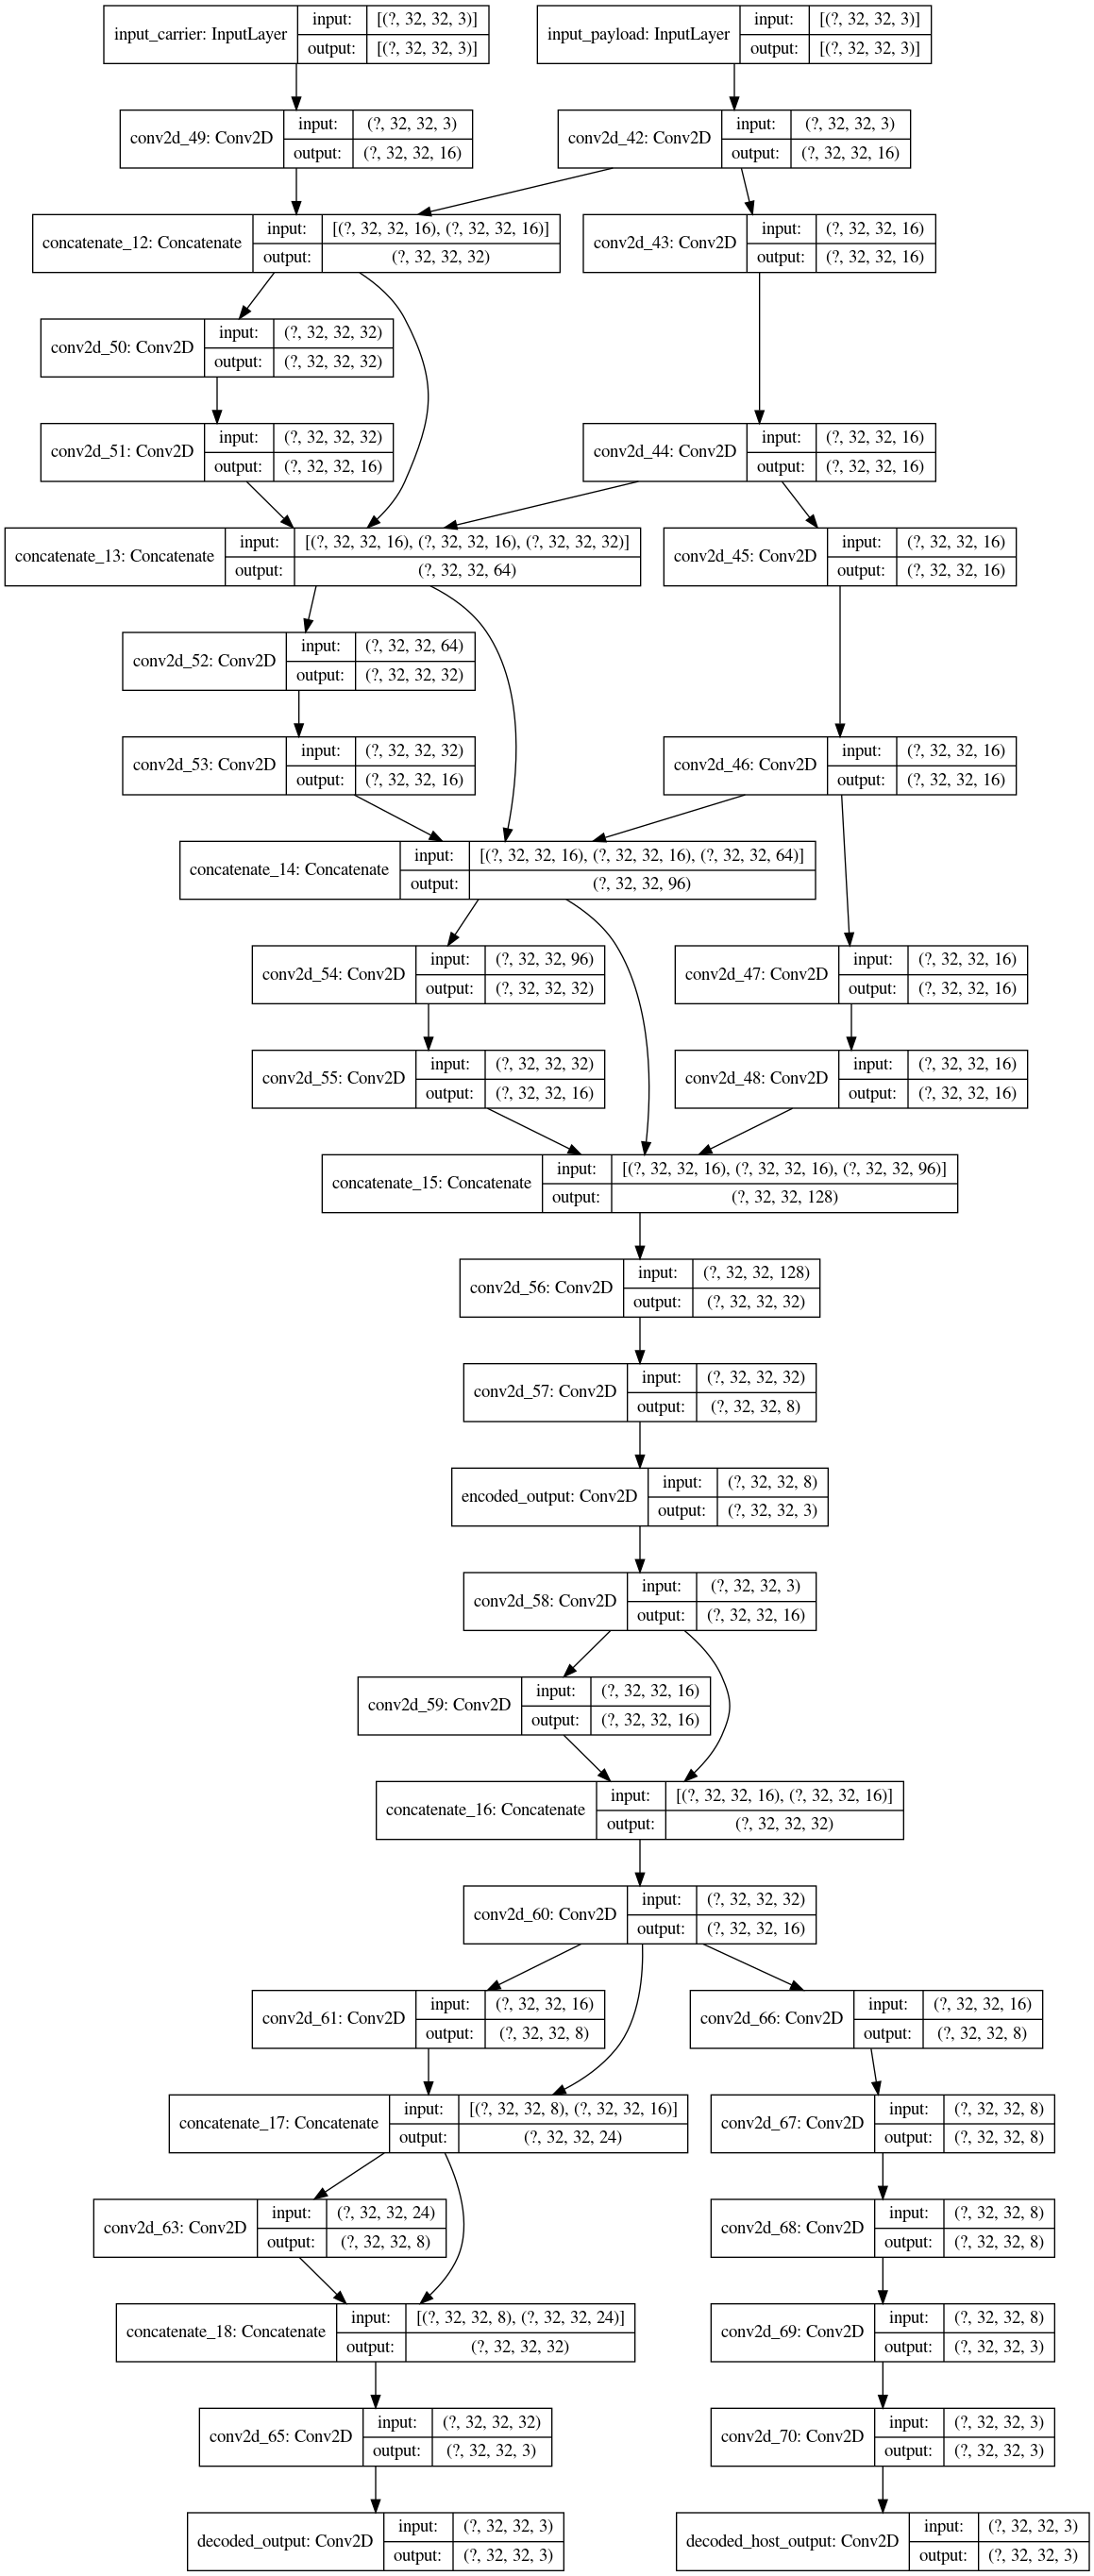

In [22]:
from tensorflow.keras.utils import plot_model
plot_model(steganography_model, show_shapes=True)

In [23]:
steganography_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_carrier (InputLayer)      [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_payload (InputLayer)      [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 32, 32, 16)   448         input_carrier[0][0]              
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 32, 32, 16)   448         input_payload[0][0]              
______________________________________________________________________________________________

In [24]:
# Defining Loss Function


@tf.function
def branched_loss_function(payload, host, encoder_output, decoder_output,
                           decoder_host_output, alpha=1., beta=2., gamma=1.):

    loss = tf.math.reduce_mean(
        beta * tf.math.squared_difference(payload, decoder_output) +
        alpha * tf.math.squared_difference(host, encoder_output) +
        gamma * tf.math.squared_difference(host, decoder_host_output))

    return loss


@tf.function
def loss_function(payload, host, encoder_output, decoder_output):

    loss = tf.math.reduce_mean(
        tf.math.squared_difference(payload, decoder_output) +
        tf.math.squared_difference(host, encoder_output))

    return loss

In [25]:
optimizer = tf.keras.optimizers.Adam(0.0001)

In [26]:
test_loss = tf.keras.metrics.Mean(name='test_loss')
train_loss = tf.keras.metrics.Mean(name='train_loss')


@tf.function
def train_step(payload, host):
    with tf.GradientTape() as tape:
        encoded_host, decoded_payload, decoded_host = steganography_model([host, payload])
        loss = branched_loss_function(payload, host, encoded_host, decoded_payload, decoded_host)
        train_loss(loss)
    gradients = tape.gradient(loss, steganography_model.trainable_variables)
    optimizer.apply_gradients(
        zip(gradients, steganography_model.trainable_variables))

    train_host_psnr = tf.reduce_mean(tf.image.psnr(host, encoded_host, 1))
    train_payload_psnr = tf.reduce_mean(
        tf.image.psnr(payload, decoded_payload, 1))

    train_host_ssim = tf.reduce_mean(tf.image.ssim(host, encoded_host, 1))
    train_payload_ssim = tf.reduce_mean(
        tf.image.ssim(payload, decoded_payload, 1))

    return train_host_psnr, train_payload_psnr, train_host_ssim, train_payload_ssim


@tf.function
def test_step(payload, host):
    encoded_host, decoded_payload, decoded_host = steganography_model([host, payload])
    t_loss = branched_loss_function(payload, host, encoded_host, decoded_payload, decoded_host)
    test_loss(t_loss)

    test_host_psnr = tf.reduce_mean(tf.image.psnr(host, encoded_host, 1))
    test_payload_psnr = tf.reduce_mean(
        tf.image.psnr(payload, decoded_payload, 1))

    test_host_ssim = tf.reduce_mean(tf.image.ssim(host, encoded_host, 1))
    test_payload_ssim = tf.reduce_mean(
        tf.image.ssim(payload, decoded_payload, 1))

    return test_host_psnr, test_payload_psnr, test_host_ssim, test_payload_ssim

In [27]:
import time
EPOCHS = 500
SUMMARY_DIR = './summary'

for epoch in range(EPOCHS):
    start = time.time()

    # for when payload is rgb
    train_size = x.shape[0]
    test_size = x_test.shape[0]

    payload_train_idx = np.arange(train_size)
    np.random.shuffle(payload_train_idx)
    payload_train = x[payload_train_idx]
    if payload_image_shape[-1] == 1:
        # for when payload is grayscale
        payload_train = np.expand_dims(np.mean(payload_train, axis=-1),
                                       axis=-1)

    host_train_idx = np.arange(train_size)
    np.random.shuffle(host_train_idx)
    host_train = x[host_train_idx]

    
    payload_test_idx = np.arange(test_size)
    np.random.shuffle(payload_test_idx)
    payload_test = x_test[payload_test_idx]
    if payload_image_shape[-1] == 1:
        # for when payload is grayscale
        # for when payload is grayscale
        payload_test = np.expand_dims(np.mean(payload_test, axis=-1), axis=-1)

    host_test_idx = np.arange(test_size)
    np.random.shuffle(host_test_idx)
    host_test = x_test[host_test_idx]

    # Normalization function
    def deprecated_normalize(payload, host):
        payload = tf.image.per_image_standardization(payload)
        host = tf.image.per_image_standardization(host)
        return payload, host

    def normalize(payload, host):
        payload = tf.divide(
            tf.math.subtract(payload, tf.reduce_min(payload)),
            tf.math.subtract(tf.reduce_max(payload), tf.reduce_min(payload)))
        host = tf.divide(
            tf.math.subtract(host, tf.reduce_min(host)),
            tf.math.subtract(tf.reduce_max(host), tf.reduce_min(host)))
        return payload, host

    # Instantiate the Dataset class
    train_dataset = tf.data.Dataset.from_tensor_slices(
        (payload_train, host_train))
    # Adding shuffle, normalization and batching operations to the dataset object
    train_dataset = train_dataset.map(normalize).shuffle(5000).batch(
        2048, drop_remainder=True)

    # Instantiate the test Dataset class
    test_dataset = tf.data.Dataset.from_tensor_slices(
        (payload_test, host_test))
    test_dataset = (test_dataset.map(normalize).batch(
        1024, drop_remainder=True)).shuffle(500)

    for payload, host in train_dataset:
        train_host_psnr, train_payload_psnr, train_host_ssim, train_payload_ssim = train_step(
            payload, host)

    for payload, host in test_dataset:
        test_host_psnr, test_payload_psnr, test_host_ssim, test_payload_ssim = test_step(
            payload, host)

    elapsed = time.time() - start
    print('elapsed: %f' % elapsed)

    template = 'Epoch {}, Train Loss: {}, Test Loss: {}, TrainH PSNR: {}, TrainP PSNR: {}, TestH PSNR: {}, TestP PSNR: {}, TrainH SSIM: {}, TrainP SSIM: {}, TestH SSIM: {}, TestP SSIM: {}'
    print(
        template.format(epoch + 1, train_loss.result(), test_loss.result(),
                        train_host_psnr, train_payload_psnr, test_host_psnr,
                        test_payload_psnr, train_host_ssim, train_payload_ssim,
                        test_host_ssim, test_payload_ssim))

    # Reset the metrics for the next epoch
    test_loss.reset_states()

print('Training Finished.')

elapsed: 26.270639
Epoch 1, Train Loss: 1.049035906791687, Test Loss: 0.9596575498580933, TrainH PSNR: 8.82730484008789, TrainP PSNR: 6.14981746673584, TestH PSNR: 8.880359649658203, TestP PSNR: 6.115179538726807, TrainH SSIM: 0.2251332700252533, TrainP SSIM: 0.02686212584376335, TestH SSIM: 0.22972223162651062, TestP SSIM: 0.030320990830659866
elapsed: 20.209223
Epoch 2, Train Loss: 0.9205968379974365, Test Loss: 0.6612379550933838, TrainH PSNR: 9.244903564453125, TrainP PSNR: 7.712431907653809, TestH PSNR: 9.24505615234375, TestP PSNR: 7.59984827041626, TrainH SSIM: 0.19118115305900574, TrainP SSIM: 0.09573383629322052, TestH SSIM: 0.18122301995754242, TestP SSIM: 0.09907086193561554
elapsed: 20.422361
Epoch 3, Train Loss: 0.7973243594169617, Test Loss: 0.4891398847103119, TrainH PSNR: 11.987399101257324, TrainP PSNR: 8.415752410888672, TestH PSNR: 12.031801223754883, TestP PSNR: 8.351615905761719, TrainH SSIM: 0.25243109464645386, TrainP SSIM: 0.13470962643623352, TestH SSIM: 0.2568

elapsed: 22.934009
Epoch 25, Train Loss: 0.2517513930797577, Test Loss: 0.1038142517209053, TrainH PSNR: 18.256282806396484, TrainP PSNR: 16.11914825439453, TestH PSNR: 18.228988647460938, TestP PSNR: 16.011770248413086, TrainH SSIM: 0.7035626769065857, TrainP SSIM: 0.6093684434890747, TestH SSIM: 0.7078676223754883, TestP SSIM: 0.6012905836105347
elapsed: 23.129099
Epoch 26, Train Loss: 0.24595443904399872, Test Loss: 0.09942793846130371, TrainH PSNR: 18.239925384521484, TrainP PSNR: 16.201736450195312, TestH PSNR: 18.291378021240234, TestP PSNR: 16.295703887939453, TrainH SSIM: 0.7064974904060364, TrainP SSIM: 0.6133826971054077, TestH SSIM: 0.7075774073600769, TestP SSIM: 0.6169206500053406
elapsed: 22.879324
Epoch 27, Train Loss: 0.2404782623052597, Test Loss: 0.09726426750421524, TrainH PSNR: 18.356273651123047, TrainP PSNR: 16.26295280456543, TestH PSNR: 18.3442440032959, TestP PSNR: 16.336021423339844, TrainH SSIM: 0.7140196561813354, TrainP SSIM: 0.6178261041641235, TestH SSIM:

elapsed: 22.521783
Epoch 49, Train Loss: 0.17056623101234436, Test Loss: 0.07817372679710388, TrainH PSNR: 19.428592681884766, TrainP PSNR: 17.027151107788086, TestH PSNR: 19.481788635253906, TestP PSNR: 17.11677360534668, TrainH SSIM: 0.7739416360855103, TrainP SSIM: 0.6752667427062988, TestH SSIM: 0.7746792435646057, TestP SSIM: 0.6729980111122131
elapsed: 22.635605
Epoch 50, Train Loss: 0.16865503787994385, Test Loss: 0.07433781027793884, TrainH PSNR: 19.483867645263672, TrainP PSNR: 17.547494888305664, TestH PSNR: 19.505027770996094, TestP PSNR: 17.48476791381836, TrainH SSIM: 0.7761260867118835, TrainP SSIM: 0.6804488897323608, TestH SSIM: 0.7754286527633667, TestP SSIM: 0.6806955337524414
elapsed: 22.679981
Epoch 51, Train Loss: 0.16679486632347107, Test Loss: 0.07375609874725342, TrainH PSNR: 19.65860366821289, TrainP PSNR: 17.64617919921875, TestH PSNR: 19.516101837158203, TestP PSNR: 17.640432357788086, TrainH SSIM: 0.7800708413124084, TrainP SSIM: 0.6843615770339966, TestH SS

elapsed: 22.549633
Epoch 73, Train Loss: 0.1369253695011139, Test Loss: 0.06154244393110275, TrainH PSNR: 20.024988174438477, TrainP PSNR: 18.217967987060547, TestH PSNR: 20.001392364501953, TestP PSNR: 18.304275512695312, TrainH SSIM: 0.8035188913345337, TrainP SSIM: 0.7142548561096191, TestH SSIM: 0.8013899326324463, TestP SSIM: 0.7131644487380981
elapsed: 22.414970
Epoch 74, Train Loss: 0.13590486347675323, Test Loss: 0.06134811416268349, TrainH PSNR: 20.028064727783203, TrainP PSNR: 18.252099990844727, TestH PSNR: 19.9854679107666, TestP PSNR: 18.308822631835938, TrainH SSIM: 0.8032788038253784, TrainP SSIM: 0.7130445241928101, TestH SSIM: 0.8038392066955566, TestP SSIM: 0.717624843120575
elapsed: 22.542350
Epoch 75, Train Loss: 0.13490520417690277, Test Loss: 0.06089526414871216, TrainH PSNR: 20.077800750732422, TrainP PSNR: 18.315006256103516, TestH PSNR: 20.142879486083984, TestP PSNR: 18.332189559936523, TrainH SSIM: 0.8033359050750732, TrainP SSIM: 0.7145316004753113, TestH SS

elapsed: 21.641402
Epoch 97, Train Loss: 0.11753875017166138, Test Loss: 0.07221359759569168, TrainH PSNR: 20.23528289794922, TrainP PSNR: 16.927165985107422, TestH PSNR: 20.485130310058594, TestP PSNR: 16.673126220703125, TrainH SSIM: 0.817512035369873, TrainP SSIM: 0.7224113941192627, TestH SSIM: 0.8233473300933838, TestP SSIM: 0.7044462561607361
elapsed: 21.465255
Epoch 98, Train Loss: 0.11692843586206436, Test Loss: 0.05589591711759567, TrainH PSNR: 20.419050216674805, TrainP PSNR: 18.642667770385742, TestH PSNR: 20.220905303955078, TestP PSNR: 18.720672607421875, TrainH SSIM: 0.8192444443702698, TrainP SSIM: 0.7358038425445557, TestH SSIM: 0.8181757926940918, TestP SSIM: 0.7413671016693115
elapsed: 21.522755
Epoch 99, Train Loss: 0.11629966646432877, Test Loss: 0.05448605865240097, TrainH PSNR: 20.333980560302734, TrainP PSNR: 18.82854652404785, TestH PSNR: 20.475147247314453, TestP PSNR: 18.891454696655273, TrainH SSIM: 0.8185681104660034, TrainP SSIM: 0.7392304539680481, TestH S

elapsed: 20.659093
Epoch 121, Train Loss: 0.10473990440368652, Test Loss: 0.050245024263858795, TrainH PSNR: 20.691736221313477, TrainP PSNR: 19.205101013183594, TestH PSNR: 20.642555236816406, TestP PSNR: 19.203325271606445, TrainH SSIM: 0.8333192467689514, TrainP SSIM: 0.7552781701087952, TestH SSIM: 0.8317778706550598, TestP SSIM: 0.7509863972663879
elapsed: 20.354207
Epoch 122, Train Loss: 0.1042904257774353, Test Loss: 0.04982462525367737, TrainH PSNR: 20.762012481689453, TrainP PSNR: 19.277389526367188, TestH PSNR: 20.73219108581543, TestP PSNR: 19.29939079284668, TrainH SSIM: 0.8338324427604675, TrainP SSIM: 0.7549439668655396, TestH SSIM: 0.8359296917915344, TestP SSIM: 0.757003128528595
elapsed: 20.090431
Epoch 123, Train Loss: 0.10384681075811386, Test Loss: 0.049956128001213074, TrainH PSNR: 20.63265037536621, TrainP PSNR: 19.25587272644043, TestH PSNR: 20.67444610595703, TestP PSNR: 19.1825008392334, TrainH SSIM: 0.8337937593460083, TrainP SSIM: 0.7556412816047668, TestH SS

KeyboardInterrupt: 

In [ ]:
payload_test = x_test[np.random.choice(np.arange(x_test.shape[0]),
                                       size=x_test.shape[0])]
if payload_image_shape[-1] == 1:
    # for when payload is grayscale
    # for when payload is grayscale
    payload_test = np.expand_dims(np.mean(payload_test, axis=-1), axis=-1)

host_test = x_test[np.random.choice(np.arange(x_test.shape[0]),
                                    size=x_test.shape[0])]
# Instantiate the test Dataset class
test_dataset = tf.data.Dataset.from_tensor_slices((payload_test, host_test))
test_dataset = (test_dataset.map(normalize).batch(
    256, drop_remainder=True)).shuffle(500)

for payload, host in test_dataset:
    test_host_psnr, test_payload_psnr, test_host_ssim, test_payload_ssim = test_step(
        payload, host)

print("Test Loss: ", test_loss.result(), "PSNR-H: ", test_host_psnr,
      "PSNR-P: ", test_payload_psnr)

In [58]:
def test_normalize(payload, host):
    normalized_payload = tf.divide(
        tf.math.subtract(payload, tf.reduce_min(payload)),
        tf.math.subtract(tf.reduce_max(payload), tf.reduce_min(payload)))
    normalized_host = tf.divide(
        tf.math.subtract(host, tf.reduce_min(host)),
        tf.math.subtract(tf.reduce_max(host), tf.reduce_min(host)))
    return normalized_payload, normalized_host, payload, host

## Inference

In [59]:
def normed_to_image(normed_image, min_, max_):
    return (normed_image * (max_ - min_)) + min_

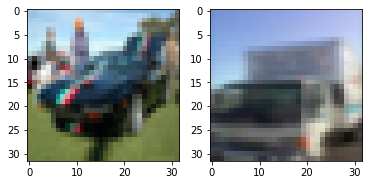

In [71]:
example_ids = np.arange(len(host_test))[:100]
example_id = np.random.choice(example_ids)

# showing host
fig, axs = plt.subplots(ncols=2)

host_example = host_test.astype(int)[example_id]
payload_example = payload_test.astype(int)[example_id]

# payload_example = np.concatenate(
#     (payload_example, payload_example, payload_example), axis=-1)
axs[0].imshow(host_example)
axs[1].imshow(payload_example, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


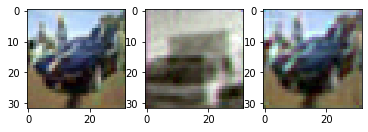

In [72]:
# showing host
fig, axs = plt.subplots(ncols=3)

inference_dataset = tf.data.Dataset.from_tensor_slices(
    (payload_test[example_ids],
     host_test[example_ids])).map(test_normalize).batch(len(example_ids))
for norm_payload, norm_host, payload, host in inference_dataset:
    encoded_host, decoded_payload, decoded_host = steganography_model(
        [norm_host, norm_payload])
    host_output = encoded_host.numpy()
    payload_output = decoded_payload.numpy()
    decoded_host_output = decoded_host.numpy()

    host_output = normed_to_image(host_output, np.min(host), np.max(host))
    payload_output = normed_to_image(payload_output, np.min(payload),
                                     np.max(payload))
    decoded_host_output = normed_to_image(decoded_host_output, np.min(host),
                                     np.max(host))

host_output = host_output.astype(int)[example_id]
payload_output = payload_output.astype(int)[example_id]
decoded_host_output = decoded_host_output.astype(int)[example_id]

# payload_output = np.concatenate(
#     (payload_output, payload_output, payload_output), axis=-1)

axs[0].imshow(host_output)
axs[1].imshow(payload_output)
axs[2].imshow(decoded_host_output)